In [1]:
# Célula 1: Importações e Configuração de Path
import pandas_ta as ta
import pandas as pd
import sys
import os # Necessário para manipulação de caminhos

# --- Adiciona o diretório src_mvp/ ao path do Python ---
# Isso permite que o notebook encontre o feature-builder.py
# Pressupõe que o notebook está rodando no diretório raiz (um nível acima de src_mvp/)

module_path = os.path.abspath(os.path.join('src_mvp'))
if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Adicionado ao sys.path: {module_path}")
# --- Fim da adição ao path ---

# Tenta importar as funções do nosso script .py
try:
    from feature_builder import load_data_from_files, create_feature_dataset
    print("Funções 'load_data_from_files' e 'create_feature_dataset' importadas com sucesso de src_mvp/feature-builder.py.")
    
except ImportError as e:
    print("\n--- ERRO DE IMPORTAÇÃO ---", file=sys.stderr)
    print("AVISO: Não foi possível encontrar 'feature_builder.py' em src_mvp/.", file=sys.stderr)
    print("Verifique se:", file=sys.stderr)
    print("  1. O arquivo 'feature-builder.py' existe dentro da pasta 'src_mvp/'.", file=sys.stderr)
    print("  2. Você está executando este notebook do diretório raiz (o diretório que *contém* a pasta 'src_mvp/').", file=sys.stderr)
    print(f"\nErro detalhado: {e}", file=sys.stderr)
    
except Exception as e:
    print(f"Ocorreu um erro inesperado durante a importação: {e}", file=sys.stderr)

Adicionado ao sys.path: C:\Users\cliente\Documents\projeto_quant_mvp\src_mvp
Funções 'load_data_from_files' e 'create_feature_dataset' importadas com sucesso de src_mvp/feature-builder.py.


In [2]:
# Célula 2: Parâmetros de Execução (Substituindo o argparse)

# --- Configuração da Execução ---

# 1. Arquivos de Entrada (Substitua pelos seus caminhos)
PATH_OHLCV = "data/raw/ohlcv_BTC_USDT_1d.csv"
PATH_NEWS = "data/raw/noticias_eventregistry_2020-10-31_a_2025-11-01.json"

# 2. Arquivo de Saída
PATH_OUTPUT = "data/processed/dataset_treino_final.csv"

# 3. Parâmetros do Modelo
GRANULARITY = "D"      # 'D' para Diário, 'H' para Horário, '4H' etc.
PERIODS_FUTURE = 1     # Horizonte de predição (1 período = 1 dia, se granularidade 'D')
# --- Fim da Configuração ---

print("Parâmetros configurados:")
print(f"  OHLCV: {PATH_OHLCV}")
print(f"  Notícias: {PATH_NEWS}")
print(f"  Saída: {PATH_OUTPUT}")
print(f"  Granularidade: {GRANULARITY}")
print(f"  Horizonte: {PERIODS_FUTURE} período(s)")

Parâmetros configurados:
  OHLCV: data/raw/ohlcv_BTC_USDT_1d.csv
  Notícias: data/raw/noticias_eventregistry_2020-10-31_a_2025-11-01.json
  Saída: data/processed/dataset_treino_final.csv
  Granularidade: D
  Horizonte: 1 período(s)


In [3]:
# Célula 2.5: Diagnóstico de Colunas

import pandas as pd
import sys

# (Pega as variáveis da Célula 2)
# Certifique-se que PATH_OHLCV e PATH_NEWS estão corretos
print(f"Iniciando diagnóstico para:")
print(f"  OHLCV: {PATH_OHLCV}")
print(f"  NOTÍCIAS: {PATH_NEWS}")
print("-" * 30)

# --- 1. Inspecionando Arquivo OHLCV (CSV) ---
print("\n--- Inspecionando Arquivo OHLCV (CSV) ---")
try:
    # Carrega apenas as 5 primeiras linhas para inspecionar
    df_ohlcv_check = pd.read_csv(PATH_OHLCV, nrows=5)
    print("Colunas encontradas no CSV:")
    print(df_ohlcv_check.columns.tolist())
    print("\nPreview dos dados CSV:")
    display(df_ohlcv_check)
except FileNotFoundError:
    print(f"ERRO: Arquivo CSV não encontrado em: {PATH_OHLCV}", file=sys.stderr)
except Exception as e:
    print(f"Erro ao ler {PATH_OHLCV}: {e}", file=sys.stderr)

print("\n" + "-" * 30)

# --- 2. Inspecionando Arquivo de Notícias (JSON) ---
print("\n--- Inspecionando Arquivo de Notícias (JSON) ---")
df_news_check = None
try:
    # Tenta ler com orient='records' (lista de dicionários)
    # Lemos o arquivo todo e pegamos o head()
    df_news_check = pd.read_json(PATH_NEWS, orient='records')
    df_news_check = df_news_check.head(5)
except ValueError:
    try:
        # Tenta ler com lines=True (JSON Lines)
        df_news_check = pd.read_json(PATH_NEWS, lines=True, nrows=5)
    except Exception as e:
        print(f"ERRO: Não foi possível carregar o arquivo JSON em {PATH_NEWS}.", file=sys.stderr)
        print(f"Detalhe: {e}", file=sys.stderr)
except FileNotFoundError:
     print(f"ERRO: Arquivo JSON não encontrado em: {PATH_NEWS}", file=sys.stderr)

if df_news_check is not None:
    print("\nColunas encontradas no JSON:")
    print(df_news_check.columns.tolist())
    print("\nPreview dos dados JSON:")
    display(df_news_check)

Iniciando diagnóstico para:
  OHLCV: data/raw/ohlcv_BTC_USDT_1d.csv
  NOTÍCIAS: data/raw/noticias_eventregistry_2020-10-31_a_2025-11-01.json
------------------------------

--- Inspecionando Arquivo OHLCV (CSV) ---
Colunas encontradas no CSV:
['datetime', 'open', 'high', 'low', 'close', 'volume']

Preview dos dados CSV:


,datetime,open,high,low,close,volume
0,2020-11-01,13791.00,13895.00,13603.00,13761.50,36285.648526
1,2020-11-02,13761.49,13830.00,13195.05,13549.37,64566.421908
2,2020-11-03,13549.63,14066.11,13284.99,14023.53,74115.630787
3,2020-11-04,14023.53,14259.00,13525.00,14144.01,93016.988262
4,2020-11-05,14144.01,15750.00,14093.56,15590.02,143741.522673



------------------------------

--- Inspecionando Arquivo de Notícias (JSON) ---

Colunas encontradas no JSON:
['articles']

Preview dos dados JSON:


,articles
results,"[{'uri': 'p-8936047848', 'lang': 'eng', 'isDup..."
totalResults,3820
pages,39


In [4]:
# Célula 3: Execução do Pipeline (O 'try...except' principal)

print("Iniciando pipeline de engenharia de features...")

try:
    # 1. Carregar Dados
    # (Usando a função importada/definida)
    df_ohlcv, df_news = load_data_from_files(PATH_OHLCV, PATH_NEWS)

    # 2. Gerar dataset de treino
    # (Usando a função importada/definida)
    df_treino = create_feature_dataset(
        df_ohlcv,
        df_news,
        granularity=GRANULARITY,
        include_target=True,  # Estamos no modo de treino
        periods_future=PERIODS_FUTURE
    )

    # 3. Salvar o Resultado
    # Filtra colunas para manter apenas features e o alvo
    features_e_target = [
        col for col in df_treino.columns 
        if col not in ['open', 'high', 'low', 'close', 'volume']
    ]
    
    df_treino_final = df_treino[features_e_target]
    
    # Salvar em CSV
    df_treino_final.to_csv(PATH_OUTPUT)
    
    print(f"\n--- SUCESSO! ---")
    print(f"Dataset de treino salvo em: {PATH_OUTPUT}")
    print("\nColunas do dataset final:")
    print(df_treino_final.columns.tolist())

except FileNotFoundError as e:
    print(f"\n--- ERRO ---", file=sys.stderr)
    print(f"Erro: Arquivo não encontrado. Verifique os caminhos em PATH_OHLCV ou PATH_NEWS.", file=sys.stderr)
    print(f"Detalhe: {e}", file=sys.stderr)
except Exception as e:
    print(f"\n--- ERRO ---", file=sys.stderr)
    print(f"Ocorreu um erro inesperado durante a execução: {e}", file=sys.stderr)

Iniciando pipeline de engenharia de features...
Carregando dados OHLCV de: data/raw/ohlcv_BTC_USDT_1d.csv
Carregando dados de Notícias (JSON aninhado) de: data/raw/noticias_eventregistry_2020-10-31_a_2025-11-01.json
Calculando indicadores técnicos...
Agregando features de sentimento na granularidade: D
Unindo datasets de preço e sentimento...
Criando variável alvo (target) para 1 período(s) à frente...
Dataset de features criado com sucesso.

--- SUCESSO! ---
Dataset de treino salvo em: data/processed/dataset_treino_final.csv

Colunas do dataset final:
['RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0', 'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP_20_2.0_2.0', 'ATRr_14', 'sentiment_mean', 'news_volume', 'target']


C:\Users\cliente\Documents\projeto_quant_mvp\src_mvp\feature_builder.py:106: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged['sentiment_mean'] = df_merged['sentiment_mean'].fillna(method='ffill')
C:\Users\cliente\Documents\projeto_quant_mvp\src_mvp\feature_builder.py:107: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged['news_volume'] = df_merged['news_volume'].fillna(method='ffill')


In [5]:
# Célula 4: (Opcional) Verificação Rápida
# Uma vantagem do notebook é inspecionar o resultado imediatamente.

print("Verificando as 5 primeiras linhas do arquivo salvo:")
try:
    df_verificacao = pd.read_csv(PATH_OUTPUT, index_col=0, parse_dates=True)
    # Exibe o 'head' do DataFrame final
    display(df_verificacao.head())
except FileNotFoundError:
    print(f"Arquivo '{PATH_OUTPUT}' não foi gerado. Verifique os erros na célula anterior.")

Verificando as 5 primeiras linhas do arquivo salvo:


,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,BBL_20_2.0_2.0,BBM_20_2.0_2.0,BBU_20_2.0_2.0,BBB_20_2.0_2.0,BBP_20_2.0_2.0,ATRr_14,sentiment_mean,news_volume,target
timestamp,,,,,,,,,,,,,
2020-12-04 00:00:00+00:00,55.946583,1048.754741,-88.134935,1136.889676,16283.740841,18193.0540,20102.367159,20.989474,0.619799,1088.207496,0.0,0.0,1
2020-12-05 00:00:00+00:00,58.926960,1021.487154,-92.322018,1113.809172,16716.266734,18352.5870,19988.907266,17.832039,0.742945,1058.835532,0.0,0.0,1
2020-12-06 00:00:00+00:00,60.163150,1005.373721,-86.748361,1092.122082,16984.309560,18484.8785,19985.447440,16.235638,0.791397,1023.418709,0.0,0.0,0
2020-12-07 00:00:00+00:00,58.441047,965.935860,-100.948977,1066.884837,17083.010718,18560.2545,20037.498282,15.918357,0.705330,987.319515,0.0,0.0,0
2020-12-08 00:00:00+00:00,51.491771,856.798325,-168.069210,1024.867535,17151.902495,18587.6540,20023.405505,15.448442,0.408221,994.999550,0.0,0.0,1


In [6]:
# Célula (Continuação): Importações da Fase 4
import sys
import os
import json # Para carregar e ver as métricas
import pandas as pd

# Adiciona src_mvp/ ao path (caso o kernel tenha sido reiniciado)
module_path = os.path.abspath(os.path.join('src_mvp'))
if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Adicionado ao sys.path: {module_path}")

# Tenta importar a função principal do nosso novo script
try:
    from model_trainer import run_training_pipeline
    print("Função 'run_training_pipeline' importada com sucesso de src_mvp/model_trainer.py.")
except ImportError as e:
    print("\n--- ERRO DE IMPORTAÇÃO ---", file=sys.stderr)
    print("AVISO: Não foi possível encontrar 'model_trainer.py' em src_mvp/.", file=sys.stderr)
    print(f"Erro detalhado: {e}", file=sys.stderr)

Função 'run_training_pipeline' importada com sucesso de src_mvp/model_trainer.py.


In [7]:
# Célula: Parâmetros de Treinamento (Fase 4)

# --- Configuração da Execução ---

# 1. Arquivo de Entrada (A saída da Célula 3 anterior)
PATH_TRAINING_DATA = "data/processed/dataset_treino_final.csv"

# 2. Arquivos de Saída (Os "artefatos" do nosso modelo)
# Vamos salvá-los em uma nova pasta 'artifacts/'
PATH_MODEL_OUTPUT = "models/trained_model.v1.pkl"
PATH_METRICS_OUTPUT = "models/training_metrics.v1.json"

# --- Fim da Configuração ---

# Cria o diretório 'artifacts' se ele não existir
os.makedirs(os.path.dirname(PATH_MODEL_OUTPUT), exist_ok=True)

print("Parâmetros de treinamento configurados:")
print(f"  Dados de Treino: {PATH_TRAINING_DATA}")
print(f"  Modelo Salvo em: {PATH_MODEL_OUTPUT}")
print(f"  Métricas Salvas em: {PATH_METRICS_OUTPUT}")

Parâmetros de treinamento configurados:
  Dados de Treino: data/processed/dataset_treino_final.csv
  Modelo Salvo em: models/trained_model.v1.pkl
  Métricas Salvas em: models/training_metrics.v1.json


In [8]:
# Célula: Execução do Pipeline de Treinamento

print("Iniciando Fase 4: Treinamento do Modelo...")

try:
    # Chama a função principal que importamos do script .py
    run_training_pipeline(
        data_path=PATH_TRAINING_DATA,
        model_output_path=PATH_MODEL_OUTPUT,
        metrics_output_path=PATH_METRICS_OUTPUT
    )

except Exception as e:
    print(f"\n--- ERRO ---", file=sys.stderr)
    print(f"Ocorreu um erro inesperado durante o treinamento: {e}", file=sys.stderr)
    raise

Iniciando Fase 4: Treinamento do Modelo...
Iniciando pipeline de treinamento com dados de: data/processed/dataset_treino_final.csv
Treinando com 10 features (sentimento IGNORADO):
['RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0', 'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP_20_2.0_2.0', 'ATRr_14']
Dividindo dados cronologicamente (Test size: 0.2)...
  1435 amostras de treino (de 2020-12-04 00:00:00+00:00 a 2024-11-07 00:00:00+00:00)
  359 amostras de teste (de 2024-11-08 00:00:00+00:00 a 2025-11-01 00:00:00+00:00)
Iniciando treinamento do XGBClassifier...
Treinamento concluído.
Avaliando modelo no conjunto de teste...

--- Relatório de Avaliação ---
Acurácia: 0.5209
              precision    recall  f1-score   support

           0       0.50      0.62      0.56       173
           1       0.55      0.42      0.48       186

    accuracy                           0.52       359
   macro avg       0.53      0.52      0.52       359
weighted a

C:\Users\cliente\Documents\projeto_quant_mvp\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:44:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [9]:
# Célula: Verificação dos Resultados

print("--- Verificação Pós-Treinamento ---")

# 1. Verificar se o modelo foi salvo
if os.path.exists(PATH_MODEL_OUTPUT):
    print(f"\n[OK] Artefato do modelo encontrado: {PATH_MODEL_OUTPUT}")
else:
    print(f"\n[FALHA] Artefato do modelo NÃO foi encontrado em {PATH_MODEL_OUTPUT}")

# 2. Carregar e exibir as métricas
if os.path.exists(PATH_METRICS_OUTPUT):
    print(f"[OK] Artefato de métricas encontrado: {PATH_METRICS_OUTPUT}")
    
    with open(PATH_METRICS_OUTPUT, 'r') as f:
        metrics = json.load(f)
        
    print("\n--- Métricas do Treinamento ---")
    print(f"Acurácia: {metrics['accuracy'] * 100:.2f}%")
    
    print("\nRelatório de Classificação (Classe 1 = Subiu):")
    # Imprime o F1-Score para a classe 1 (subiu)
    print(f"  Precisão (Classe 1): {metrics['classification_report']['1']['precision']:.4f}")
    print(f"  Recall (Classe 1):   {metrics['classification_report']['1']['recall']:.4f}")
    print(f"  F1-Score (Classe 1): {metrics['classification_report']['1']['f1-score']:.4f}")
    
    print("\nMatriz de Confusão:")
    # Recria o DataFrame do pandas para uma exibição bonita no notebook
    cm_df = pd.DataFrame(
        metrics['confusion_matrix'], 
        index=[f"Real_{i}" for i in [0, 1]], 
        columns=[f"Pred_{i}" for i in [0, 1]]
    )
    display(cm_df)
    
else:
    print(f"\n[FALHA] Artefato de métricas NÃO foi encontrado em {PATH_METRICS_OUTPUT}")

--- Verificação Pós-Treinamento ---

[OK] Artefato do modelo encontrado: models/trained_model.v1.pkl
[OK] Artefato de métricas encontrado: models/training_metrics.v1.json

--- Métricas do Treinamento ---
Acurácia: 52.09%

Relatório de Classificação (Classe 1 = Subiu):
  Precisão (Classe 1): 0.5486
  Recall (Classe 1):   0.4247
  F1-Score (Classe 1): 0.4788

Matriz de Confusão:


,Pred_0,Pred_1
Real_0,108,65
Real_1,107,79


In [10]:
# Célula: Instalação da Fase 5
# O vectorbt é uma poderosa biblioteca de backtesting.
# Descomente e execute se você ainda não a tem:
!pip install vectorbt


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
# Célula (Continuação): Instalação e Importações da Fase 5

# Descomente para instalar se for a primeira vez
# !pip install vectorbt

import pandas as pd
import vectorbt as vbt
import sys
import os
import importlib  # <-- A FERRAMENTA DE CORREÇÃO

# Adiciona src_mvp/ ao path
module_path = os.path.abspath(os.path.join('src_mvp'))
if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Adicionado ao sys.path: {module_path}")

# --- A CORREÇÃO MÁGICA ---
# Importa o módulo normalmente
import backtester 
# Força o Python a reler o arquivo .py do disco
importlib.reload(backtester) 

# Importa a função específica DEPOIS do reload
from backtester import run_backtest_pipeline
# --- FIM DA CORREÇÃO ---

print("Função 'run_backtest_pipeline' importada e RECARREGADA com sucesso.")

Função 'run_backtest_pipeline' importada e RECARREGADA com sucesso.


In [12]:
# Célula: Parâmetros do Backtest (Fase 5)

# --- Configuração da Execução ---

# 1. Artefatos das Fases 3 e 4
PATH_MODEL = "models/trained_model.v1.pkl"
PATH_TRAINING_DATA = "data/processed/dataset_treino_final.csv"

# 2. Dados Brutos Originais (para alinhamento de preço)
#    **Ajuste estes caminhos**
PATH_OHLCV = "data/raw/ohlcv_BTC_USDT_1d.csv"
PATH_NEWS = "data/raw/noticias_eventregistry_2020-10-31_a_2025-11-01.json"

# 3. Parâmetro da Estratégia
#    Deve corresponder à granularidade do seu 'feature-builder.py'
GRANULARITY = 'D' # 'D' para Diário, 'H' para Horário

# --- Fim da Configuração ---

print("Parâmetros de backtesting configurados.")

Parâmetros de backtesting configurados.


In [13]:
# Célula: Execução do Pipeline de Backtesting

print("Iniciando Fase 5: Backtesting e Validação Quantitativa...")

try:
    # Chama a função principal que importamos do script .py
    portfolio = run_backtest_pipeline(
        model_path=PATH_MODEL,
        feature_data_path=PATH_TRAINING_DATA,
        ohlcv_data_path=PATH_OHLCV,
        news_data_path=PATH_NEWS, # Necessário para o alinhamento
        granularity=GRANULARITY
    )
    
    print("\nExecução concluída. Exibindo métricas financeiras...")

    # --- Exibição de Resultados ---
    print("\n" + "="*50)
    print("--- Métricas Financeiras (pf.stats()) ---")
    print("="*50)
    
    # O display() do Jupyter formata a tabela de estatísticas
    display(portfolio.stats())
    
except Exception as e:
    print(f"\n--- ERRO ---", file=sys.stderr)
    print(f"Ocorreu um erro inesperado durante o backtest: {e}", file=sys.stderr)
    raise

Iniciando Fase 5: Backtesting e Validação Quantitativa...
Iniciando pipeline de backtesting...
Carregando dados OHLCV de: data/raw/ohlcv_BTC_USDT_1d.csv
Carregando dados de Notícias (JSON aninhado) de: data/raw/noticias_eventregistry_2020-10-31_a_2025-11-01.json
Alinhando features e dados de preço...
Executando backtest APENAS no conjunto de teste (20% finais)...
Dividindo dados cronologicamente (Test size: 0.2)...
  1435 amostras de treino (de 2020-12-04 00:00:00+00:00 a 2024-11-07 00:00:00+00:00)
  359 amostras de teste (de 2024-11-08 00:00:00+00:00 a 2025-11-01 00:00:00+00:00)
Gerando sinais (predições) do modelo...
Executando simulação (Frequência: D) usando preço 'open'...


C:\Users\cliente\Documents\projeto_quant_mvp\src_mvp\backtester.py:94: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\cliente\Documents\projeto_quant_mvp\src_mvp\backtester.py:95: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Backtest concluído.

Execução concluída. Exibindo métricas financeiras...

--- Métricas Financeiras (pf.stats()) ---


Start                         2024-11-08 00:00:00+00:00
End                           2025-11-01 00:00:00+00:00
Period                                359 days 00:00:00
Start Value                                       100.0
End Value                                    135.483477
Total Return [%]                              35.483477
Benchmark Return [%]                          44.491245
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              10.106063
Max Drawdown Duration                  79 days 00:00:00
Total Trades                                         52
Total Closed Trades                                  51
Total Open Trades                                     1
Open Trade PnL                                -0.510857
Win Rate [%]                                  62.745098
Best Trade [%]                                10.299849
Worst Trade [%]                               -4


--- Visualização Gráfica (Equity Curve & Trades) ---
Gerando gráfico interativo...



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


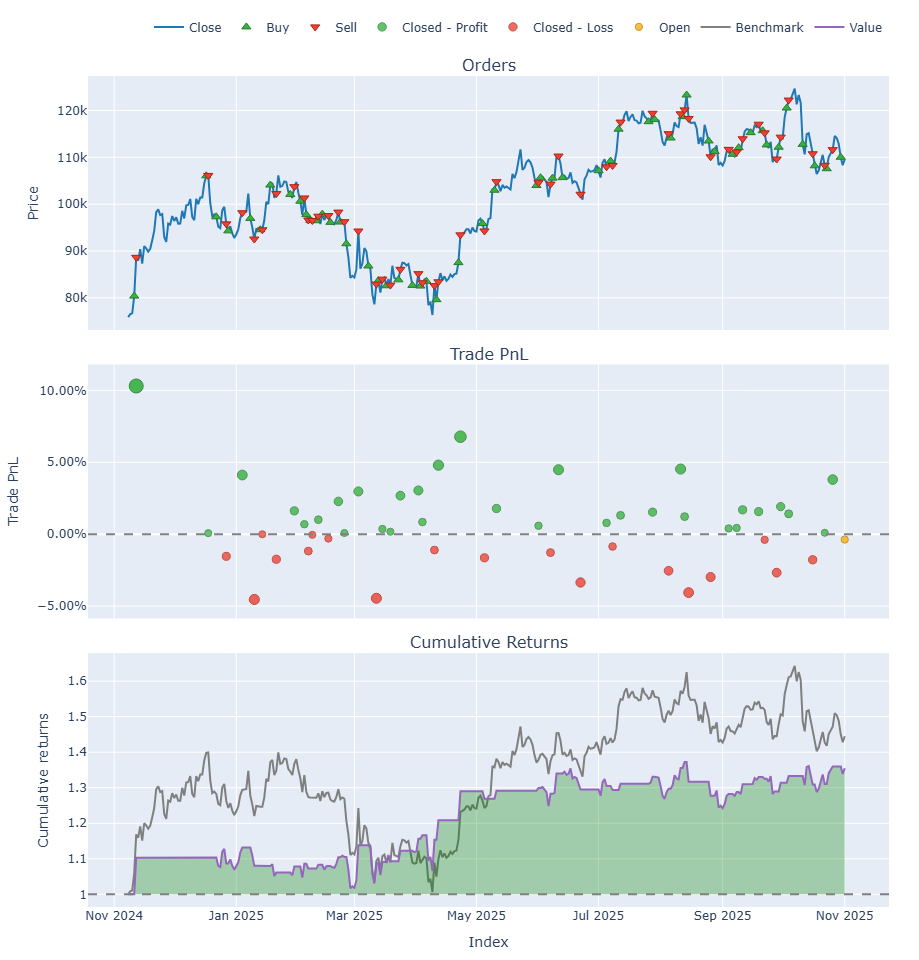

In [14]:
# Célula: Visualização Gráfica (Plotly)
!pip install anywidget

print("\n" + "="*50)
print("--- Visualização Gráfica (Equity Curve & Trades) ---")
print("="*50)
print("Gerando gráfico interativo...")

try:
    # Gera o gráfico interativo que mostra:
    # 1. Curva de Capital (Azul) vs. Benchmark (Cinza)
    # 2. Pontos de Compra (Verde) e Venda (Vermelho)
    portfolio.plot().show()

except NameError:
    print("Erro: O objeto 'portfolio' não foi criado com sucesso na célula anterior.", file=sys.stderr)
except Exception as e:
    print(f"Ocorreu um erro ao gerar o gráfico: {e}", file=sys.stderr)